# Introduction

# Imports and Datasets

In [113]:
import sys
assert sys.version_info >= (3,5)
import os
import pathlib

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import nltk
from collections import Counter

from scipy.spatial.distance import cosine

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers

#import mlflow
#from mlflow import log_metric, log_param, log_artifacts
#import mlflow.tensorflow
#from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


random_state=42
tf.random.set_seed(random_state)
np.random.seed(random_state)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
#kaggle = 0 # Kaggle path active = 1

# change your local path here
if iskaggle:
    PHRASES_PATH= '../input/us-patent-phrase-to-phrase-matching'
else:
    PHRASES_PATH= '../phrase2phrase-match-ai/data/input/us-patent-phrase-to-phrase-matching'



for dirname, _, filenames in os.walk(PHRASES_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version: 2.7.0
Keras Version: 2.7.0
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
../phrase2phrase-match-ai/data/input/us-patent-phrase-to-phrase-matching\sample_submission.csv
../phrase2phrase-match-ai/data/input/us-patent-phrase-to-phrase-matching\test.csv
../phrase2phrase-match-ai/data/input/us-patent-phrase-to-phrase-matching\train.csv


## Get the Data

In [103]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(PHRASES_PATH,CSV_FILE_TRAIN)
test = load_csv_data(PHRASES_PATH,CSV_FILE_TEST)

## Prepare the Data

### Data Understanding
- id - a unique identifier for a pair of phrases
- anchor - the first phrase
- target - the second phrase
- context - the CPC classification (version 2021.05), which indicates the subject within which the similarity is to be scored
- score - the similarity. This is sourced from a combination of one or more manual expert ratings.


#### Score
The scores are in the 0-1 range with increments of 0.25 with the following meanings:

- 1.0 - Very close match. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
- 0.75 - Close synonym, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
- 0.5 - Synonyms which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
- 0.25 - Somewhat related, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
- 0.0 - Unrelated.

In [104]:
train['anchor'].value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [105]:
train['target'].value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

In [106]:
train['score'].value_counts()

0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: score, dtype: int64

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  rasterized: bool
  sketch_params: (scale: float, length: float, randomness: float)
 

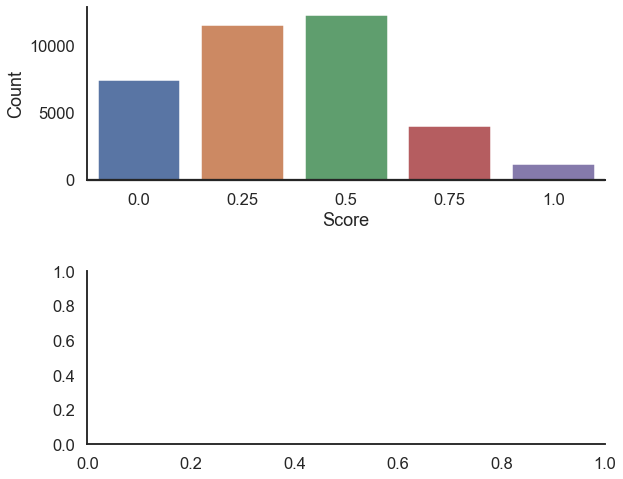

In [107]:
sns.set_theme(style="white", context="talk")

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7))

y_val = train['score'].value_counts().values
x_val = train['score'].value_counts().index.values
sns.barplot(x=x_val, y=y_val, palette="deep", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Count")
ax1.set_xlabel("Score")

sns.despine(bottom=False)
plt.setp(f.axes)
plt.tight_layout(h_pad=2)

## Natural Language Processing

In [108]:
train['corpus'] = train['anchor'] + ', ' + train['target']


## N-Gram From The Corpus 


In [112]:
train['corpus'].to_list()


['abatement, abatement of pollution',
 'abatement, act of abating',
 'abatement, active catalyst',
 'abatement, eliminating process',
 'abatement, forest region',
 'abatement, greenhouse gases',
 'abatement, increased rate',
 'abatement, measurement level',
 'abatement, minimising sounds',
 'abatement, mixing core materials',
 'abatement, multi pollution abatement device',
 'abatement, noise reduction',
 'abatement, pollution abatement',
 'abatement, pollution abatement incinerator',
 'abatement, pollution certificate',
 'abatement, rent abatement',
 'abatement, sorbent material',
 'abatement, source items pollution abatement technology',
 'abatement, stone abutments',
 'abatement, tax abatement',
 'abatement, water bodies',
 'abatement, emission abatement',
 'abatement, prevention',
 'abatement, prophylaxis',
 'abatement, pollution abatement',
 'abatement, abatement apparatus',
 'abatement, treatment',
 'abatement, abatement apparatus',
 'abatement, abating',
 'abatement, central hub'

### Data Preparation, Tockenization and Transformation


In [61]:
train

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [62]:
# y = train[['id','score']].copy()
# X = train[['id','anchor','target','context']].copy()

In [63]:
#y

In [64]:
#X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=random_state, test_size=0.2)

In [65]:
train

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


## Word 2 Vector Approach

In [68]:
sentece = train['anchor']
words = {}
word = sentece[0]
vector = np.array([float(x) for x in sentece[1:]])
words[word] = vector

ValueError: could not convert string to float: 'abatement'

## Model Building